<a href="https://colab.research.google.com/github/kosmasrio0411/Final-Project-PCD/blob/main/Final_Project_PCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# 1. Install dan import library
# ============================================================
import os
from pathlib import Path
import numpy as np
import cv2
import kagglehub
from tqdm import tqdm

import matplotlib.pyplot as plt

from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.draw import polygon
from skimage.feature import graycomatrix, graycoprops
from scipy import ndimage as ndi

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Untuk menghindari warning yang mengganggu
import warnings
warnings.filterwarnings("ignore")


In [2]:
# ============================================================
# 2. Download dataset TBX-11 dari Kaggle dengan kagglehub
# ============================================================

dataset_path = kagglehub.dataset_download("usmanshams/tbx-11")
print("Dataset path:", dataset_path)

# Lihat isi folder paling atas
print("Top-level files/folders:", os.listdir(dataset_path))


100%|██████████| 3.08G/3.08G [02:23<00:00, 23.1MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/usmanshams/tbx-11/versions/1
Top-level files/folders: ['TBX11K']


In [3]:
# ============================================================
# 3. Utilitas: cari semua path image dan buat label TB vs Non-TB
# ============================================================
# Di TBX11K biasanya kelasnya: Healthy, Sick but non-TB, Active TB, Latent TB, Uncertain TB.
# Kita ubah menjadi biner:
#    TB     : Active TB, Latent TB, Active&Latent TB
#    Non-TB : Healthy, Sick but non-TB
# Uncertain TB bisa di-skip.

IMAGE_EXTS = (".png", ".jpg", ".jpeg")

def list_all_images(root_dir):
    root = Path(root_dir)
    paths = []
    for p in root.rglob("*"):
        if p.suffix.lower() in IMAGE_EXTS:
            paths.append(str(p))
    return paths

def map_path_to_binary_label(path_str):
    """
    Mengembalikan:
      1 = TB
      0 = Non-TB
      None = tidak dipakai (misal Uncertain TB)
    Mapping dilakukan berdasarkan nama folder yang muncul di path.
    Sesuaikan jika nama folder di dataset kamu berbeda.
    """
    parts = [part.lower() for part in Path(path_str).parts]

    category = None

    for p in parts:
        if "uncertain" in p:
            category = "uncertain"
            break
        if "healthy" in p or "normal" in p:
            category = "healthy"
            break
        if "sick" in p and "tb" not in p:
            category = "sick_non_tb"
            break
        if "non-tb" in p or "nontb" in p:
            category = "sick_non_tb"
            break
        if "active" in p and "tb" in p:
            category = "active_tb"
            break
        if "latent" in p and "tb" in p:
            category = "latent_tb"
            break
        # fallback sangat kasar: kalau nama foldernya persis "tb"
        if p == "tb":
            category = "tb"
            break

    if category in ["active_tb", "latent_tb", "tb"]:
        return 1      # TB
    elif category in ["healthy", "sick_non_tb"]:
        return 0      # Non-TB
    else:
        return None   # tidak dipakai

all_image_paths = list_all_images(dataset_path)
print("Total image files ditemukan:", len(all_image_paths))

# Ubah ke list berisi (path, label_biner)
labeled_paths = []
for p in all_image_paths:
    label = map_path_to_binary_label(p)
    if label is not None:
        labeled_paths.append((p, label))

print("Total image yang dipakai setelah mapping TB vs Non-TB:", len(labeled_paths))

# Opsional: batasi jumlah per kelas supaya training cepat
MAX_PER_CLASS = 1200  # silakan naikkan kalau komputernya kuat

tb_paths = [p for p, y in labeled_paths if y == 1][:MAX_PER_CLASS]
nontb_paths = [p for p, y in labeled_paths if y == 0][:MAX_PER_CLASS]

paths_balanced = tb_paths + nontb_paths
labels_balanced = [1]*len(tb_paths) + [0]*len(nontb_paths)

print("Jumlah TB:", len(tb_paths))
print("Jumlah Non-TB:", len(nontb_paths))


Total image files ditemukan: 12279
Total image yang dipakai setelah mapping TB vs Non-TB: 4600
Jumlah TB: 800
Jumlah Non-TB: 1200


In [4]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def preprocess_image(img):
    # Baca grayscale

    # Resize
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)

    # CLAHE (adaptHistEq versi OpenCV)
    img = clahe.apply(img)

    # Gaussian filter
    img = cv2.GaussianBlur(img, (5, 5), 0)

    return img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

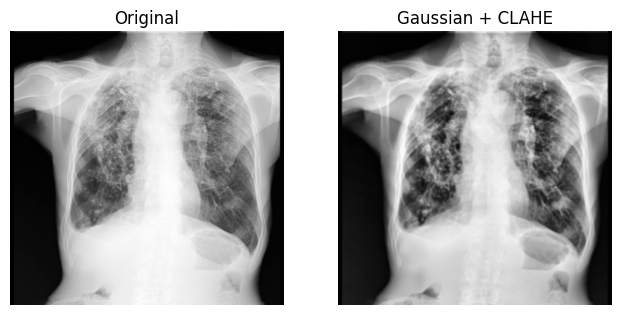

In [5]:
sample_img = cv2.imread(paths_balanced[0], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)


plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Gaussian + CLAHE"); plt.axis("off")



In [173]:
import cv2
import numpy as np
from scipy import ndimage as ndi

def get_body_mask(img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    h, w = img.shape

    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, body = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    body = cv2.morphologyEx(body, cv2.MORPH_CLOSE, k, iterations=1)

    body[int(0.95 * h):, :] = 0

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(body)
    mask = np.zeros_like(img, np.uint8)
    if num_labels > 1:
        main = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = (labels == main).astype(np.uint8)

    mask = ndi.binary_fill_holes(mask > 0).astype(np.uint8)
    return mask

def segment_lungs_final(img_pre, debug=False):
    # 1. pastikan uint8
    img = np.clip(img_pre, 0, 255).astype(np.uint8)
    h, w = img.shape

    # 2. body mask
    body_mask = get_body_mask(img).astype(np.uint8)
    body_area = body_mask.sum()
    if body_area == 0:
        lung_mask = np.zeros_like(img, np.uint8)
        return img, lung_mask

    # 3. nol-kan di luar badan
    img_body = img.copy()
    img_body[body_mask == 0] = 0

    # 4. Otsu di area badan
    blur = cv2.GaussianBlur(img_body, (5, 5), 0)
    torso_pixels = blur[body_mask == 1].reshape(-1, 1)

    thresh_val, _ = cv2.threshold(
        torso_pixels, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )

    # 5. apply ambang sekali saja dengan NumPy (paru lebih gelap)
    lung_bin = np.zeros_like(img, np.uint8)
    lung_bin[(blur < thresh_val) & (body_mask == 1)] = 255

    # 6. OPEN kecil + fill holes awal
    k_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    lung_bin = cv2.morphologyEx(lung_bin, cv2.MORPH_OPEN, k_small, iterations=2)
    lung_mask_tmp = ndi.binary_fill_holes(lung_bin > 0).astype(np.uint8)

    # 7. CC: pilih 1–2 blob terbesar
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(lung_mask_tmp)
    lung_mask = np.zeros_like(img, np.uint8)
    if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        idx = np.argsort(areas)[-2:]          # indeks di stats[1:]
        chosen = (idx + 1).tolist()           # label asli
        lung_mask = np.isin(labels, chosen).astype(np.uint8)

    # 8. batasi ke body, fill holes, smooth akhir
    lung_mask[body_mask == 0] = 0
    lung_mask = ndi.binary_fill_holes(lung_mask > 0).astype(np.uint8)

    r = max(int(0.01 * min(h, w)), 2)
    k_smooth = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * r + 1, 2 * r + 1))
    lung_mask = cv2.morphologyEx(lung_mask, cv2.MORPH_CLOSE, k_smooth, iterations=3)
    lung_mask = ndi.binary_fill_holes(lung_mask > 0).astype(np.uint8)

    if debug:
        print("lung area ratio:", lung_mask.sum() / (h * w + 1e-8))

    segmented = img * lung_mask
    return segmented, lung_mask


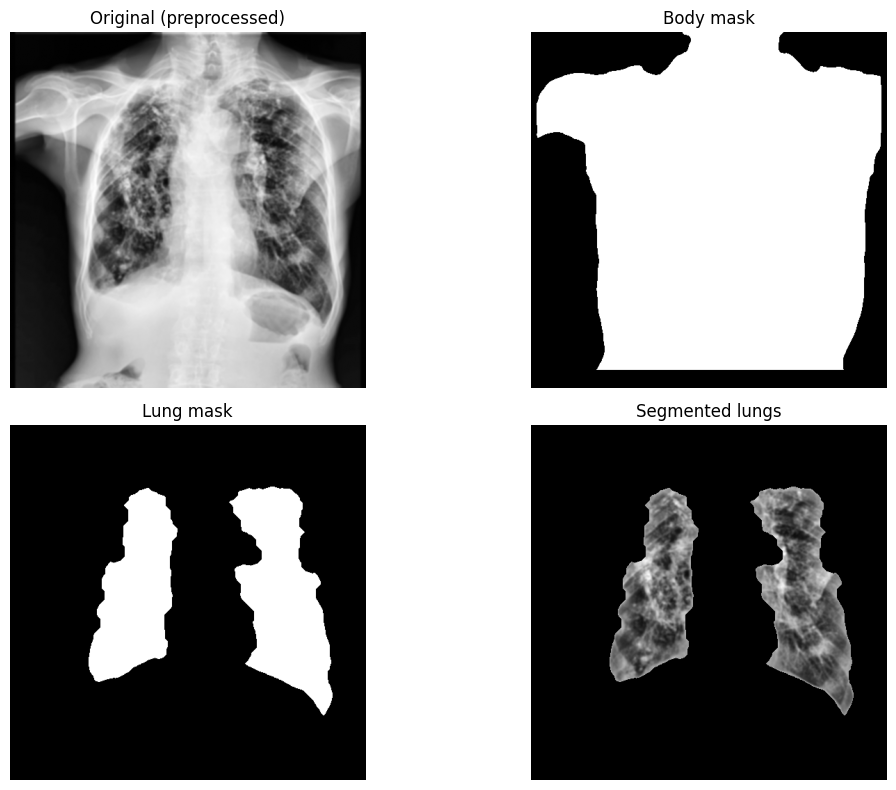

In [174]:
import matplotlib.pyplot as plt
sample_img = cv2.imread(paths_balanced[0], cv2.IMREAD_GRAYSCALE)
pre = preprocess_image(sample_img)
segmented, lung_mask = segment_lungs_final(pre)  # atau segment_lungs_final


# 1. ambil body_mask dari gambar preprocessed
body_mask = get_body_mask(pre)

# 2. pastikan juga kamu sudah punya segmented & lung_mask
# segmented, lung_mask = segment_lungs_simple(pre, debug=True)

# 3. plot semuanya
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Original (preprocessed)")
plt.imshow(pre, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Body mask")
plt.imshow(body_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Lung mask")
plt.imshow(lung_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Segmented lungs")
plt.imshow(segmented, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


lung area ratio: 0.19061279296874273
mask sum: 49968


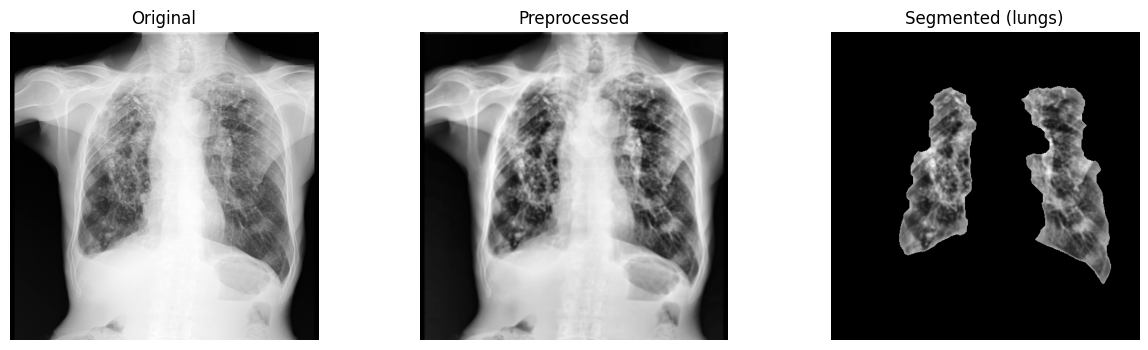

mask sum: 43501


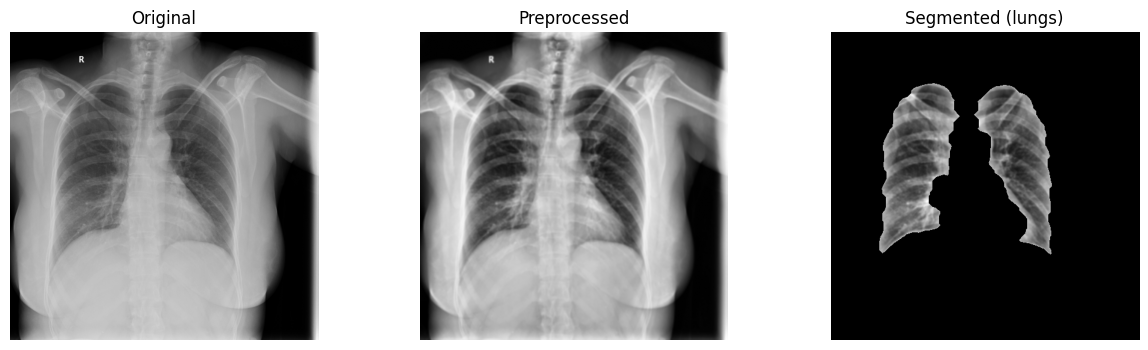

mask sum: 56290


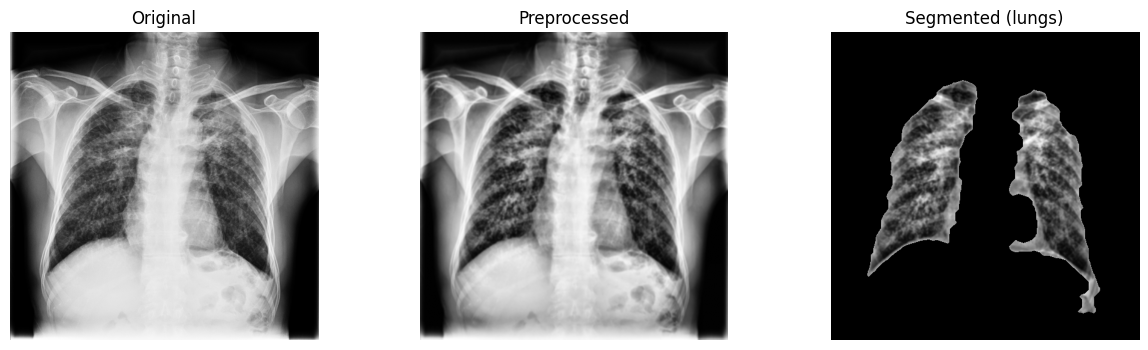

mask sum: 69837


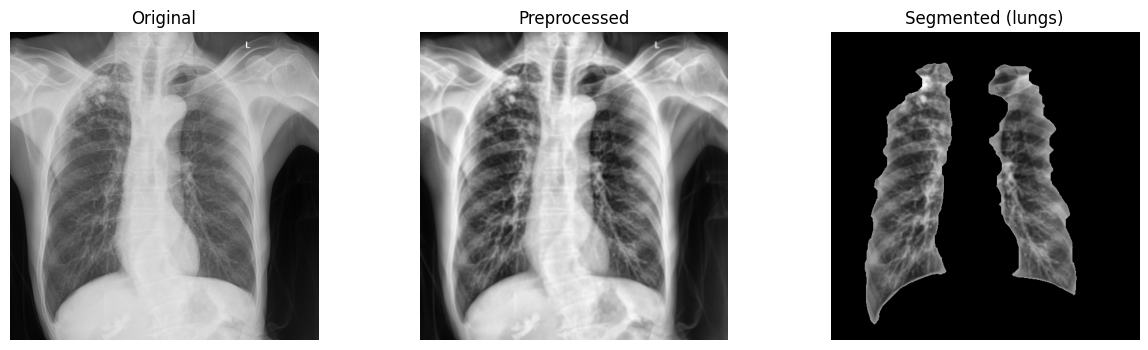

mask sum: 56558


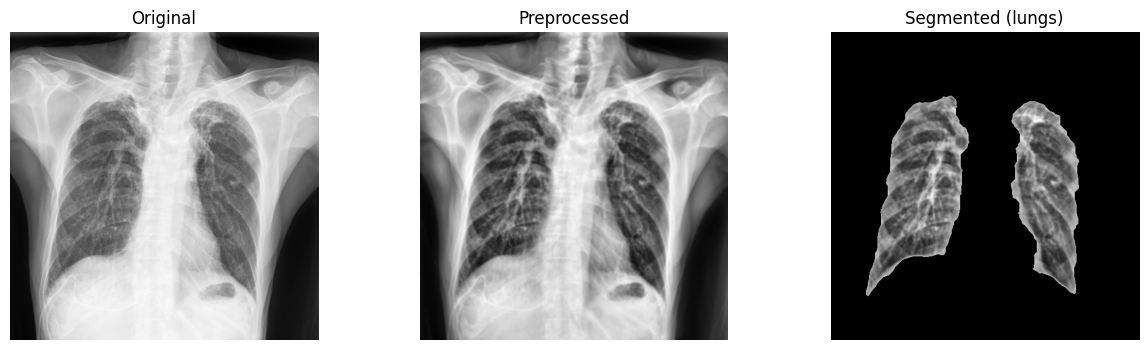

mask sum: 65100


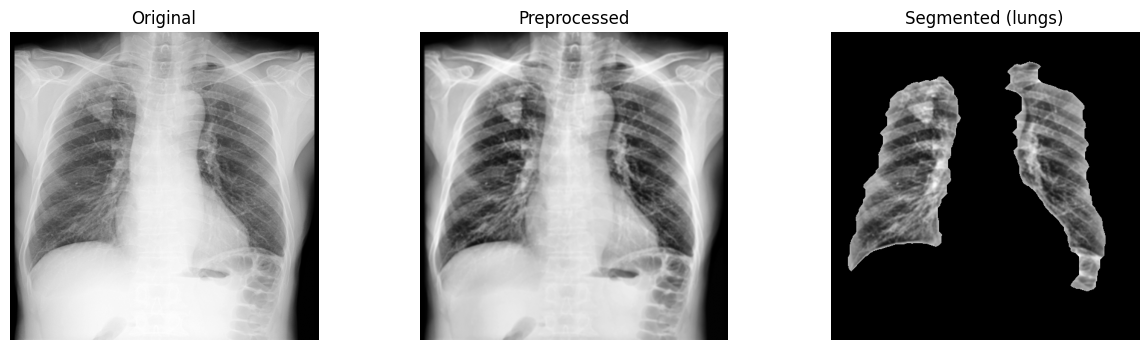

mask sum: 61054


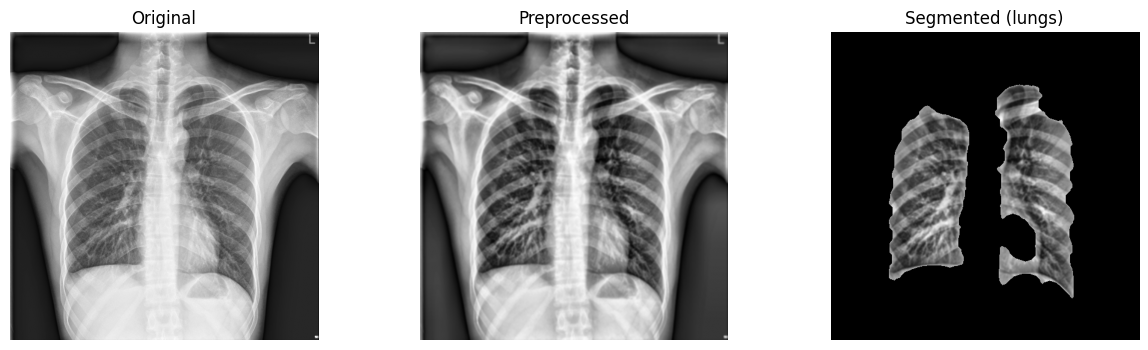

mask sum: 69791


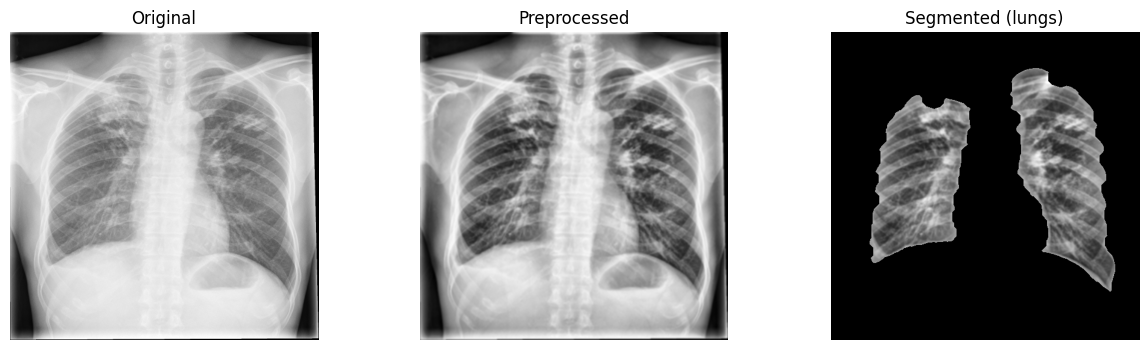

mask sum: 77779


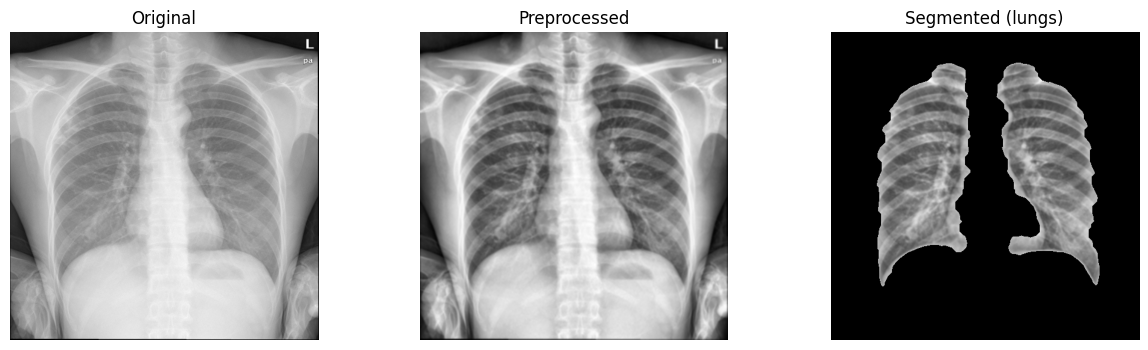

In [175]:
sample_img = cv2.imread(paths_balanced[0], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre, debug=True)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[1], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()


sample_img = cv2.imread(paths_balanced[2], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[3], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[4], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()


sample_img = cv2.imread(paths_balanced[5], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[6], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[7], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()


sample_img = cv2.imread(paths_balanced[8], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()



In [176]:
# ============================================================
# 6. Ekstraksi fitur: GLCM + PCA
# ============================================================
from skimage.feature import graycomatrix, graycoprops

def glcm_features(img,
                  distances=(1, 2, 4),
                  angles=(0, np.pi/4, np.pi/2, 3*np.pi/4),
                  levels=16):
    """
    Ekstraksi fitur GLCM:
    - quantisasi ke 'levels' gray level
    - untuk setiap prop GLCM, simpan SEMUA nilai untuk setiap (distance, angle)
      => 6 * len(distances) * len(angles) fitur
    """
    # pastikan uint8
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    # Quantize ke 0..levels-1
    img_q = (img / (256 // levels)).astype(np.uint8)

    glcm = graycomatrix(
        img_q,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    props = ["contrast", "dissimilarity", "homogeneity",
             "energy", "correlation", "ASM"]

    feat = []
    for prop in props:
        values = graycoprops(glcm, prop)   # shape: [len(distances), len(angles)]
        feat.extend(values.flatten())      # simpan SEMUA kombinasi jarak×sudut

    return np.array(feat, dtype=np.float32)


# Test 1 gambar
test_feat = glcm_features(seg)
print("Panjang vektor fitur GLCM:", test_feat.shape[0])

def glcm_stat_features(img,
                       distances=(1, 2, 4),
                       angles=(0, np.pi/4, np.pi/2, 3*np.pi/4),
                       levels=16):
    """
    Ekstraksi fitur:
    - 6 fitur GLCM: contrast, dissimilarity, homogeneity, energy, correlation, ASM
      -> disimpan SEMUA nilai untuk setiap (distance, angle)
         => 6 * len(distances) * len(angles) fitur
    - 8 fitur statistik intensitas: mean, std, entropy, RMS, variance, smoothness, kurtosis, skewness

    img: hasil segmentasi paru (seg_img), uint8 (0..255)
    return: vektor fitur 1D (float32)
    """

    # pastikan uint8
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    h, w = img.shape

    # ==========================
    # 1) STATISTICAL FEATURES (8)
    # ==========================
    roi_vals = img[img > 0].astype(np.float32)  # hanya piksel paru (mask != 0)
    if roi_vals.size == 0:
        roi_vals = img.reshape(-1).astype(np.float32)

    mean_val = roi_vals.mean()
    std_val  = roi_vals.std()

    # entropy dari histogram
    hist, _ = np.histogram(roi_vals, bins=levels, range=(0, 255), density=True)
    hist = hist + 1e-12
    entropy = -np.sum(hist * np.log2(hist))

    # RMS & variance
    rms = np.sqrt(np.mean((roi_vals - mean_val) ** 2))
    variance = std_val ** 2

    # smoothness: 1 - 1/(1 + σ²)
    smoothness = 1.0 - 1.0 / (1.0 + variance)

    # kurtosis & skewness
    if std_val > 1e-6:
        z = (roi_vals - mean_val) / std_val
        kurtosis = np.mean(z**4) - 3.0
        skewness = np.mean(z**3)
    else:
        kurtosis = 0.0
        skewness = 0.0

    stat_feats = [
        mean_val, std_val, entropy, rms,
        variance, smoothness, kurtosis, skewness
    ]

    # ==========================
    # 2) GLCM FEATURES (6 × D × A)
    # ==========================
    # quantisasi
    step = max(256 // levels, 1)
    img_q = (img // step).astype(np.uint8)

    # bisa pakai bounding box paru biar GLCM tidak didominasi background
    ys, xs = np.where(img > 0)
    if len(xs) > 0:
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()
        img_q_sub = img_q[y_min:y_max+1, x_min:x_max+1]
    else:
        img_q_sub = img_q

    glcm = graycomatrix(
        img_q_sub,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    props = ["contrast", "correlation", "homogeneity",
             "energy", "entropy", "variance"]

    glcm_feats = []
    for p in props:
        vals = graycoprops(glcm, p)   # shape: [len(distances), len(angles)]
        glcm_feats.extend(vals.flatten())  # SIMPAN semua jarak × sudut

    # gabungkan: [GLCM per d×θ] + [8 statistik]
    feats = np.array(glcm_feats + stat_feats, dtype=np.float32)
    return feats



Panjang vektor fitur GLCM: 72


In [177]:
# ============================================================
# 7. Bangun dataset fitur untuk semua gambar
# ============================================================

X_features = []
y_labels = []

for path, label in tqdm(zip(paths_balanced, labels_balanced), total=len(paths_balanced)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    pre_img = preprocess_image(img)
    seg_img, _ = segment_lungs_final(pre_img)

    feat = glcm_stat_features(seg_img)   # <- SEpKARANG sudah include jarak×sudut
    X_features.append(feat)
    y_labels.append(label)

X_features = np.vstack(X_features)
y_labels = np.array(y_labels)

print("Shape fitur:", X_features.shape)
print("Shape label:", y_labels.shape)


100%|██████████| 2000/2000 [02:51<00:00, 11.65it/s]

Shape fitur: (2000, 80)
Shape label: (2000,)


##SVM

In [178]:
# ============================================================
# 8. Train-test split, standardisasi, PCA, dan SVM
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

# Standardisasi
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# PCA (Feature Optimization)
pca = PCA(n_components=0.95, random_state=42)  # simpan 95% varian
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("Dimensi awal:", X_train_std.shape[1])
print("Dimensi setelah PCA:", X_train_pca.shape[1])

# SVM classifier
svm_clf = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    probability=False,
    class_weight="balanced",
    random_state=42
)

svm_clf.fit(X_train_pca, y_train)
y_pred = svm_clf.predict(X_test_pca)


Dimensi awal: 80
Dimensi setelah PCA: 5


In [179]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

def evaluate_binary_model(model, X_train, y_train, X_test, y_test,
                          pos_label=1, name="Model"):
    # ===== TRAIN =====
    y_tr_pred = model.predict(X_train)
    cm_tr = confusion_matrix(y_train, y_tr_pred, labels=[0, 1])
    tn_tr, fp_tr, fn_tr, tp_tr = cm_tr.ravel()

    acc_tr  = accuracy_score(y_train, y_tr_pred)
    sens_tr = recall_score(y_train, y_tr_pred, pos_label=pos_label)
    spec_tr = tn_tr / (tn_tr + fp_tr + 1e-12)

    print(f"=== {name} – TRAIN PERFORMANCE ===")
    print("Confusion Matrix (Train):\n", cm_tr)
    print(f"Accuracy (Train)              : {acc_tr:.4f}")
    print(f"Sensitivity (Recall TB, Train): {sens_tr:.4f}")
    print(f"Specificity (Recall Non-TB)   : {spec_tr:.4f}\n")

    # ===== TEST =====
    y_te_pred = model.predict(X_test)
    cm_te = confusion_matrix(y_test, y_te_pred, labels=[0, 1])
    tn, fp, fn, tp = cm_te.ravel()

    acc_te  = accuracy_score(y_test, y_te_pred)
    sens_te = recall_score(y_test, y_te_pred, pos_label=pos_label)
    spec_te = tn / (tn + fp + 1e-12)

    print(f"=== {name} – TEST PERFORMANCE ===")
    print("Confusion Matrix (Test):\n", cm_te)
    print(f"Accuracy (Test)               : {acc_te:.4f}")
    print(f"Sensitivity (Recall TB, Test) : {sens_te:.4f}")
    print(f"Specificity (Recall Non-TB)   : {spec_te:.4f}")


In [180]:
evaluate_binary_model(svm_clf, X_train_pca, y_train, X_test_pca, y_test,
                      name="SVM")

=== SVM – TRAIN PERFORMANCE ===
Confusion Matrix (Train):
 [[853 107]
 [ 85 555]]
Accuracy (Train)              : 0.8800
Sensitivity (Recall TB, Train): 0.8672
Specificity (Recall Non-TB)   : 0.8885

=== SVM – TEST PERFORMANCE ===
Confusion Matrix (Test):
 [[203  37]
 [ 28 132]]
Accuracy (Test)               : 0.8375
Sensitivity (Recall TB, Test) : 0.8250
Specificity (Recall Non-TB)   : 0.8458


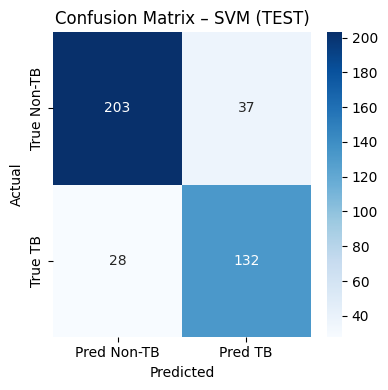

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# prediksi test
y_test_pred = svm_clf.predict(X_test_pca)

# confusion matrix (0 = Non-TB, 1 = TB)
cm_te = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

plt.figure(figsize=(4, 4))
sns.heatmap(cm_te,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Pred Non-TB", "Pred TB"],
            yticklabels=["True Non-TB", "True TB"])
plt.title("Confusion Matrix – SVM (TEST)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


##Logistic Regression

In [182]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(
    penalty="l2",
    C=1.0,
    class_weight="balanced",
    max_iter=1000,
    solver="lbfgs",
    random_state=42
)

log_clf.fit(X_train_pca, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [183]:
evaluate_binary_model(log_clf, X_train_pca, y_train, X_test_pca, y_test,
                      name="Logistic Regression")

=== Logistic Regression – TRAIN PERFORMANCE ===
Confusion Matrix (Train):
 [[773 187]
 [127 513]]
Accuracy (Train)              : 0.8037
Sensitivity (Recall TB, Train): 0.8016
Specificity (Recall Non-TB)   : 0.8052

=== Logistic Regression – TEST PERFORMANCE ===
Confusion Matrix (Test):
 [[199  41]
 [ 35 125]]
Accuracy (Test)               : 0.8100
Sensitivity (Recall TB, Test) : 0.7812
Specificity (Recall Non-TB)   : 0.8292


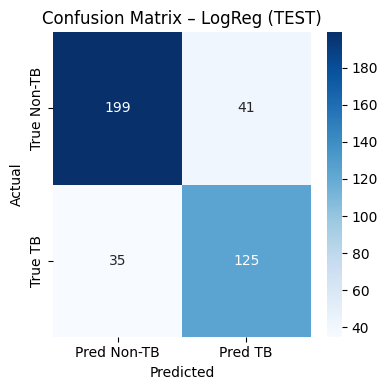

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# prediksi test
y_test_pred = log_clf.predict(X_test_pca)

# confusion matrix (0 = Non-TB, 1 = TB)
cm_te = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

plt.figure(figsize=(4, 4))
sns.heatmap(cm_te,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Pred Non-TB", "Pred TB"],
            yticklabels=["True Non-TB", "True TB"])
plt.title("Confusion Matrix – LogReg (TEST)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
